# Investigation of a surfactant monolayer

A common system that is studied with neutron and X-ray reflectometry are surfactant monolayers. 
In this tutorial, we will look at how the `EasyReflectometry` item `SurfactantLayer` ([detailed here](./item_library.html#surfactantlayer)) can be used to model a phospholipid bilayer. 
First, we will import the relevant packages and functions.

First configure matplotlib to place figures in notebook and import needed modules

In [1]:
%matplotlib inline

import EasyReflectometry
import refnx
from EasyReflectometry.data import load
from EasyReflectometry.plot import plot
from EasyReflectometry.sample.material import Material
from EasyReflectometry.sample.item import SurfactantLayer
from EasyReflectometry.sample import Layer, Structure
from EasyReflectometry.experiment.model import Model
from EasyReflectometry.interface import InterfaceFactory as Interface
from EasyReflectometry.fitting import Fitter

Next, as usual we print the versions of the software packages. 

In [2]:
print(f'EasyReflectometry: {EasyReflectometry.__version__}')
print(f'refnx: {refnx.__version__}')

EasyReflectometry: 0.0.3
refnx: 0.1.41


## Reading in experimental data

As has been [shown previously](./simple_fitting.html), we use the `load` function to read in our experimental data. 
For this tutorial we will be looking at [DSPC](https://en.wikipedia.org/wiki/Distearoylphosphatidylcholine), a phospholipid molecule that will self-assemble into a monolayer at the air-water interface. 
The data being used has kindly been shared by the authors of [previous work on the system](#hollinshead2009). 

/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/orsopy/fileio/base.py:277: RuntimeWarning: Has to be one of ('neutron', 'x-ray') got neutrons
  warnings.warn(


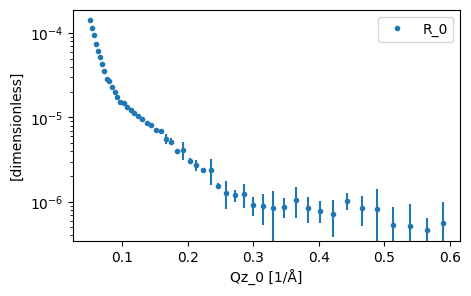

In [3]:
data = load('_static/d70d2o.ort')
plot(data)

## Building the model

The study of surfactant monolayers is very popular in the literature, including the models based on [functional descriptions](#hollinshead2009), [slab models](#campbell2018), and [molecular dynamics simulations](#mccluskey2019). 
In `EasyReflectometry`, we use a slab model description taht has become particularly commonplace. 
A graphical representation of the slab model for a phosphoplipid monolayer is shown below.

<center>
    <img src='_static/monolayer.png' alt='A slab model description for a phospholipid monolayer.' width='300px'></img>
</center>
<center>
    A slab model description for a phospholipid monolayer, showing the head and tail layers.
</center>

The slab model for a phospholipid monolayer involves describing the system as consisting of two components, that for the hydrophilic head group layer and that for the hydrophobic tail group layer. 
Each of these layers have some thickness that can be estimated by considering the size of the head and tail groups.
The scattering length density ($\rho$) for the layers is then defined based on the layer thickness ($d$), the scattering length for the component ($b$), the surface number density of the monolayer (defined by the area per molecule, $\mathrm{APM}$) and the amount of solvent present in the layer ($\phi$), where the solvent has a known scattering length density ($\rho_{\mathrm{solvent}}$), 

$$ \rho = \frac{b}{d\mathrm{APM}}(1-\phi) + \rho_{\mathrm{solvent}}\phi. $$

This approach has two benefits: 
1. By constraining the area per molecule of the head and tail groups to be the same, the analysis can ensure that the number density of the two components is equal (i.e. for every head group there is a tail group), as would be expected given the chemical bonding.
2. The area per molecule is a parameter that can be measured using complementary methods, such as surface-pressure isotherm, to help define the value.

Finally, we can constrain the roughness between head-tail and tail-superphase layers to be the same value, as it is unlikely that it would be different. 

Before we create the `SurfactantLayer` object, we will create simple `Material` objects for the sub- and super-phase. 

In [4]:
d2o = Material.from_pars(6.36, 0, 'D2O')
air = Material.from_pars(0, 0, 'Air')

### Building the surfactant monolayer

Now we can create the `SurfactantLayer` object, this takes a large number of parameters, that we will introduce gradually. 

<center>
    <img src='_static/dspc.png' alt='The chemical structure for the DSPC molecule.' width='400px'></img>
</center>
<center>
    The chemical structure for the DSPC molecule. By <a href='https://commons.wikimedia.org/w/index.php?curid=97726650'>Graeme Bartlett - Self Drawn, CC0</a>
</center>

The chemical structure for the DSPC molecule is shown above, where the head group is everything to the right of (and including) the ester group as this is the hydrophilic component. 
While, everything to the left hand side is the tail group (both chains are included).
We want to define the chemical formula for each of these subunits. 

In [5]:
head_formula = 'C10H18NO8P'
tail_formula = 'C34D70'

Next we define estimates for the thickness of each layer, for this we will use values from [a previous work](#mccluskey2020), as we will not be varying these parameters. 

In [6]:
head_thickness = 12.9
tail_thickness = 17.6

We expect the head layer to be solvated with some of the D<sub>2</sub>O present, however it is unlikely that there will be any solvation (by D<sub>2</sub>O or air) in the tighly packed tails. 

In [7]:
head_solvation = 0.5
tail_solvation = 0.0

Finally, we define the values for the area per molecule and roughness for the whole surfactant layer. 

In [8]:
area_per_molecule = 45
roughness = 3

Having created the necessary initial values, we can use these to create a `SurfactantLayer` object. 
Note that the area per molecule and roughness for both layers are the same. 
We can also print information about our surfactant system.

In [9]:
dspc = SurfactantLayer.from_pars(tail_formula, tail_thickness, air, tail_solvation, 
                                 area_per_molecule, roughness,
                                 head_formula, head_thickness, d2o, head_solvation, 
                                 area_per_molecule, roughness)
dspc.constrain_apm = True
dspc.conformal_roughness = True
dspc

layer1:
  EasySurfactantLayer Layer 1:
    material:
      C34D70/Air:
        fraction: 0.0
        sld: 8.753e-6 1 / angstrom ** 2
        isld: 0.000e-6 1 / angstrom ** 2
        material1:
          C34D70:
            sld: 8.753e-6 1 / angstrom ** 2
            isld: 0.000e-6 1 / angstrom ** 2
        material2:
          Air:
            sld: 0.000e-6 1 / angstrom ** 2
            isld: 0.000e-6 1 / angstrom ** 2
    thickness: 17.600 angstrom
    roughness: 3.000 angstrom
  chemical_structure: C34D70
  area_per_molecule: 45.0 angstrom ** 2
layer2:
  EasySurfactantLayer Layer 2:
    material:
      C10H18NO8P/D2O:
        fraction: 0.5
        sld: 3.697e-6 1 / angstrom ** 2
        isld: 0.000e-6 1 / angstrom ** 2
        material1:
          C10H18NO8P:
            sld: 1.035e-6 1 / angstrom ** 2
            isld: 0.000e-6 1 / angstrom ** 2
        material2:
          D2O:
            sld: 6.360e-6 1 / angstrom ** 2
            isld: 0.000e-6 1 / angstrom ** 2
    thickness: 1

The layers for the sub- and super-phase are then created. 

In [10]:
d2o_layer = Layer.from_pars(d2o, 0, 3, 'D2O Subphase')
air_layer = Layer.from_pars(air, 0, 0, 'Air Superphase')

For the surfactant layer, the roughness is typically defined by the roughness between the water-head layers. 
Therefore, it is desirable to add this constraint to our model.

In [11]:
dspc.constrain_solvent_roughness(d2o_layer.roughness)

Now that the surfactant layer and sub- and super-phases are available and the necessary constraints present, we construct our `Structure` and `Model` objects. 

In [12]:
structure = Structure.from_pars(air_layer, dspc, d2o_layer)
model = Model.from_pars(structure, 1, data['data']['R_0'].values.min(), 5)

For the `model` we set the background initially as the minimum value observed in the experimental data. 

## Defining bounds and performing the optimisation

The varying parameters can then be defined, in this case we will let the scale factor, the background, the surfactant area per molecule, and head layer solvation vary with the bounds shown below. 

In [13]:
model.scale.bounds = (0.05, 1.5)
model.background.bounds = (4e-7, 1e-6)

dspc.layers[0].area_per_molecule.bounds = (30, 60)
dspc.layers[1].solvation.bounds = (0.4, 0.7)

Finally, as with other [tutorials](./tutorials.html), we create the `Interface` (and connect this to our model) and `Fitter` objects and perform the fit. 

In [14]:
interface = Interface()
model.interface = interface
fitter = Fitter(model)
analysed = fitter.fit(data, method='differential_evolution')

The result can then be plotted, before we investigate the results. 

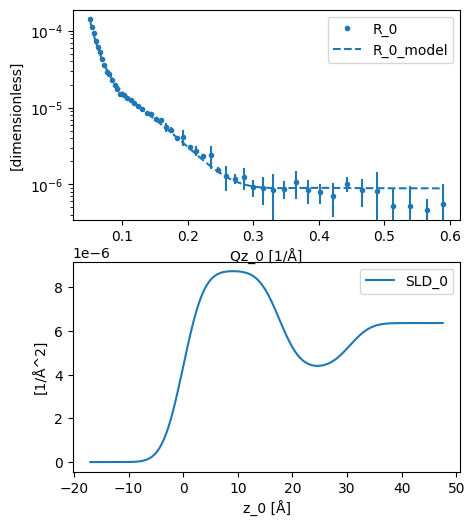

In [15]:
plot(analysed)

In [16]:
model

EasyModel:
  scale: 0.14027978383298884
  background: 8.859564467588116e-07
  resolution: 5.0 %
  structure:
    EasyStructure:
    - Air Superphase:
        material:
          Air:
            sld: 0.000e-6 1 / angstrom ** 2
            isld: 0.000e-6 1 / angstrom ** 2
        thickness: 0.000 angstrom
        roughness: 0.000 angstrom
    - layer1:
        EasySurfactantLayer Layer 1:
          material:
            C34D70/Air:
              fraction: 0.0
              sld: 8.753e-6 1 / angstrom ** 2
              isld: 0.000e-6 1 / angstrom ** 2
              material1:
                C34D70:
                  sld: 8.753e-6 1 / angstrom ** 2
                  isld: 0.000e-6 1 / angstrom ** 2
              material2:
                Air:
                  sld: 0.000e-6 1 / angstrom ** 2
                  isld: 0.000e-6 1 / angstrom ** 2
          thickness: 17.600 angstrom
          roughness: 3.000 angstrom
        chemical_structure: C34D70
        area_per_molecule: 53.2 angstro

We can see above that the solvation of the surfactant was found to be around 60 % and the area per molecule around 50 Å<sup>2</sup>, in agreement with [previous investigations](#mccluskey2019). 

## References 

<div id='hollinshead2009'></div>
Hollinshead, C. M., Harvey, R. D., Barlow, D. J., Webster, J. R. P., Hughes, A. V., Weston, A., Lawrence, M. J., **2009**,
*Effects of Surface Pressure on the Structure of Distearoylphosphatidylcholine Monolayers Formed at the Air/Water Interface*,
[Langmuir, 25, 4070-4077](https://doi.org/10.1021/la8028319)

<div id='campbell2018'></div>
Campbell, R. A., Saaka, Y., Shao, Y., Gerelli, Y., Cubitt, R., Nazaruk, E., Matyszewska, D. Lawrence, M. J., **2018**,
*Structure of surfactant and phospholipid monolayers at the air/water interface modeled from neutron reflectivity data*,
[Journal of Colloid and Interface Science, 531, 98-108](https://doi.org/10.1016/j.jcis.2018.07.022)

<div id='mccluskey2019'></div>
McCluskey, A. R., Grant, J., Smith, A. J., Rawle, J. L., Barlow, D. J., Lawrence, M. J., Parker, S. C., Edler, K. J., **2019**,
*Assessing molecular simulation for the analysis of lipid monolayer reflectometry*,
[Journal of Physics Communications, 3, 075001](https://doi.org/10.1088/2399-6528/ab12a9)

<div id='mccluskey2020'></div>
McCluskey, A. R., Cooper, J. F. K., Arnold, T., Snow, T., **2020**,
*A general approach to maximise information density in neutron reflectometry analysis*,
[Machine Learning: Science and Technology, 1, 035002](https://doi.org/10.1088/2632-2153/ab94c4)